## [나의 가위바위보 분류기 만들기]

가위바위보 분류기를 처음으로 설계해보려 합니다.    아직 잘은 모르겠지만 노드들을 꼼꼼하게 읽어보며 필요한 하이퍼파라미터들을 수정하며 진행하려 합니다.   이번 태스크의 목표는 **딥러닝에 입문하기와 결과를 즐겨보기** 입니다


### 0. 환경을 설정해줍니다   
tensorflow에서 keras와    
numpy를 불러와줍니다. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

###  1. 필요한 데이터를 준비합니다
구글 [teachable machine](https://teachablemachine.withgoogle.com/) 페이지에서 가위, 바위, 보의 사진을 100장씩 찍어 각각 디렉토리를 형성해줍니다    (rock_scissor_paper의 하위 디렉토리로 scissor, rock, paper을 형성해줍니다.)   
저는 제 손만 나오는 식으로 다양한 각도에서 찍어줬습니다. 제 사진들은 **test set**에 넣어줄 생각입니다.   

디렉토리를 만들 때 사용하는 명령어는 ```$ mkdir -p```입니다.

노드에서 강조한   -"좋은 데이터가 좋은 결과를 낳는다는 것을 꼭 기억하세요!" 라는 문구를 마음에 품고 진행합니다. 


### 2.데이터를 알맞은 크기로 줄여줍니다.   

처음 다운로드 받은 데이터는 224x224 픽셀입니다. 이미지 크기를 28x28로 리사이징해서 학습시킬 계획입니다.    
리사이징을 위해 **PIL라이브러리**를 사용합니다    
```python
!pip install pillow   

from PIL import Image
import os, glob
```   
로 PIL라이브러리를 다운로드 받은 후 불러와줍니다.

In [2]:
from PIL import Image
import os, glob

###### glob명령어로 가위 이미지가 저장된 폴더의 모든 jpg를 불러옵니다. 

```python
import os
image_dir_path = os.getenv("HOME") + "/rock_scissor_paper/scissor"
images=glob.glob(image_dir_path + "/*.jpg")
```


###### 28x28로 리사이징 해줍니다
```python
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")
    ```
*같은 방식으로 rock과 paper도 리사이징 해줍니다*

### 3. Train set 구성하기   
train set을 구성해줍니다. 저는 다른 분들의 이미지를 추가로 불러와 총 10500장의 이미지를 데이터베이스에 포함시켜주었습니다.   
(10500,28,28,3)으로 구성된 데이터 영역에 이미지 행렬을 복사해 넣어준 후 레이블링을 해줍니다.    
0(가위)   
1(바위)   
2(보)    
   
**RGB이미지**이기 때문에 (10500,28,28,**3**)으로 코드를 수정해서 넣어줍니다.

In [3]:

def load_data(img_path):
    number_of_data=10500  #다른 분들이 올려주신 사진들을 다운받아서 총 10500개의 트레이닝 데이터를 학습시켰습니다. 근데 jpeg로 저장된 파일들이 300개가 전부 반영되지는 않았습니다.
    img_size=28
    color=3
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1 
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2 
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/rock_scissor_paper/train/"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0  

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))  

학습데이터(x_train)의 이미지 개수는 10200 입니다.
x_train shape: (10500, 28, 28, 3)
y_train shape: (10500,)


라벨:  0


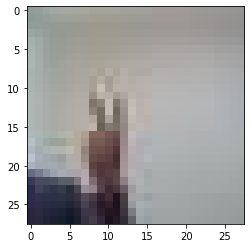

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

#### 딥러닝 네트워크 모델을 확인해봅니다

In [5]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               102528    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

### 네트워크를 학습시킵니다    
모델 입력 형태가 ```x_train_reshape```이니 그에 맞춰  model.fit을 사용합니다.    
10,500의 데이터를 총 10번 학습시켰습니다.   accuracy가 0.9964까지 올라가네요.

In [6]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)

Epoch 1/10
329/329 [==============================] - 1s 3ms/step - loss: 7.1416 - accuracy: 0.5148
Epoch 2/10
329/329 [==============================] - 1s 3ms/step - loss: 0.4597 - accuracy: 0.8159
Epoch 3/10
329/329 [==============================] - 1s 3ms/step - loss: 0.2802 - accuracy: 0.8968
Epoch 4/10
329/329 [==============================] - 1s 3ms/step - loss: 0.1320 - accuracy: 0.9544
Epoch 5/10
329/329 [==============================] - 1s 3ms/step - loss: 0.1207 - accuracy: 0.9581
Epoch 6/10
329/329 [==============================] - 1s 3ms/step - loss: 0.0836 - accuracy: 0.9732
Epoch 7/10
329/329 [==============================] - 1s 3ms/step - loss: 0.0540 - accuracy: 0.9827
Epoch 8/10
329/329 [==============================] - 1s 3ms/step - loss: 0.0672 - accuracy: 0.9764
Epoch 9/10
329/329 [==============================] - 1s 3ms/step - loss: 0.0240 - accuracy: 0.9929
Epoch 10/10
329/329 [==============================] - 1s 3ms/step - loss: 0.0697 - accuracy: 0.9799

### Test set 구성하기   
train set과 같은 방법으로 test set을 구성해줍니다. test set에는 총 600개의 데이터가 포함되어 있습니다. 

In [7]:
def load_data(img_path):
    number_of_data=600  
    img_size=28
    color=3
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img     
        labels[idx]=0  
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=1   
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=2   
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/rock_scissor_paper/test/"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 600 입니다.
x_test shape: (600, 28, 28, 3)
y_test shape: (600,)


라벨:  0


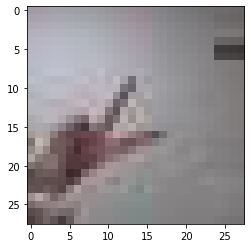

In [8]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

### TEST 데이터로 문제 풀어보기    
지금까지 만들었던 Train data로 Test set을 돌려봅니다. 잘 돌아갈까요?   
우리에게 필요한 레이블 값은 가위, 바위, 보로 총 3개이니 ```model.add(keras.layers.Dense(3, activation='softmax'))```로 데이터 값이 3이 맞는지 확인해줍니다.


In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


19/19 - 0s - loss: 1.1023 - accuracy: 0.6917
test_loss: 1.1022770404815674 
test_accuracy: 0.6916666626930237


### 네트워크 성능 올리기

load data 에서 nuber of data 값을 600으로 설정했는데 실질적인 test set의 사진 갯수는 300개일 때 accuracy가 0.6667까지 올라갔었다.    왜 이러나 고민을 해봤는데 같은 데이터를 두번 돌리기 때문에 정확도가 두배가 되었던 것 같다.    생각보다 accuracy를 올리기가 어려운 것 같다. 

##### 다양한 시도들


- 12, 24, 120 => 0.4683    
- 12, 24, 64 => 0.3333
- train set의 epoch 값을 10에서 20으로 늘려봤다. 19부터 정확도가 떨어지기 시작하여 18로 수정했다.     

이 과정을 기록하기 전부터 n번 반복했는데 0.3333의 늪에 빠졌다. 테스트 셋을 300개로 고정하고 다른 사람의 데이터로 교체하도 변화가 없다.

- 트레인셋을 들여다봤다. 대부분의 사람들이 본인의 손을 찍어 올려주셨는데 어떤 분이 상반신 전체를 올려주셔서 그 분이 트레인 데이터를 오염시키는 것 같아 트레인셋에서 그 분의 데이터를 제외하고 다시 돌려봤다     

- 12, 24, 64 => 0.3750    
- 12, 24, 64 => 0.3333    
- 12, 24, 120 => 0.3333   

도저히 accuracy 값이 올라가지 않아서 train set 학습데이터를 확인해봤더니 학습 accuracy 값이 0.3724로 낮았다. 
- 재학습 후 0.9872  
- epoch = 15 accuracy = 0.9861

test set의 하이퍼파라미터를 재조정
- 6, 12, 246 => 0.2950    
- 32, 64, 64 => 0.3333
- 32, 64, 6 => 0.3684       
파라미터를 재조정하는 과정을 n번 거쳤으나 0.3점대에서 벗어나지 못함   
- 6, 32, 12 => 0.3267
- 6, 32, 64 => 0.3483

## <실습 후에 얻은 질문들>
#### Q. 왜 하이퍼파라미터 값을 조정하면 할 수록 값이 떨어질까요? 
#### Q. 수십번 시도 후에도 정확도를 올릴 수 없다면 시도할 수 있는 방법에는 무엇이 있을까요?

## 문제해결

```python
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()
``` 

라는 구문을 test데이터 구성시에도 넣어뒀었다. 그리고 test set에서만 의미없는 반복 수정을 반복하고 있었는데(실질적으로 train에는 반영되지 않는 값) 그러니 절대로 accuracy가 높아질 수 없는 구조. 필요 없는 구문을 제거하고 처음부터 재학습시키니 **0.6917**이라는 아름다운 수치를 얻었다. 박수박수.

### 후기   
- 온갖 하이퍼파라미터들을 변경해보고 트레인셋과 테스트셋에 넣은 데이터들도 변경해 보았으나 나의 accuracy는 최대 0.4683을 넘지 못했다. 하이퍼파라미터를 조정하면 할 수록 오히려 0.3333이라는 늪에 빠지는 것 같아서 고통스럽다. 개발자들이 딥러닝을 돌리기 전에 제사를 지내는 짤방 같은걸 본 적이 있는데 학습 결과는 정말 운에 달린것일까? 같은 조인 민규님은 3번만에 0.6점대가 나왔다고 해서 부러웠다. 나는 끝이 없는 감옥에 갇힌것 같아 괴롭다. 문제가 뭘까요?

- 혼자 찾아보다 너무 모르겠어서 팀원분들에게 help를 요청했다. 내가 못 찾던 문제를 팀원분은 한번에 찾아봐서 역시 코딩은 맑은 정신에 해야하는구나. 오기가 생긴다고 4시간째 하이퍼파라미터들을 바꾸고 데이터를 수정하고 있었는데 답은 생각보다 간편한 곳에 있었다. 그래도 끝낼 수 있어 행복해요.